
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [287]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
idx=3

In [289]:
import time
import math
from scipy.stats import gmean,chi2
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import itertools
from joblib import Parallel, delayed

adjClose = pd.read_csv(f"MMF1921_AssetPrices_{idx}.csv", index_col=0)
factorRet = pd.read_csv(f"MMF1921_FactorReturns_{idx}.csv", index_col=0)

In [290]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [291]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months)
investPeriod = 6

factorRet = factorRet

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];


In [292]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [293]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [294]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

In [295]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

#End of the first investment period
testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])
insample_r2 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
        #Initial portfolio weights
        x0[:,0] = np.zeros(n)
    else:
        currentVal[t] = currentPrices @ NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    # The project function is in the services folder
    # Take in the period returns and period factor returns and produce
    # an allocation
    #----------------------------------------------------------------------
    # optimal: 0.00,0.0,0.990,0.0,0.85,-1.00,0.25
    objective_lambda_dict = {
        'portfolio_variance': 0,# this is fixed
        'turnover': 0,
        'ellipsoidal_robustness':chi2.ppf(0.99,n),
        'cvar':0,
        'cvar_alpha':0.85,
        'enet_lambda':-1.00,
        'enet_alpha':0.25,
        'prediction_model':1
        # 'ellipsoidal_robustness':0,
    }
    x[:,t],insample_r2[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], objective_lambda_dict)
    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

# 3. Results

In [296]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))
print('Composite Objective: ', str(0.8*SR[0] - 0.2*(avgTurnover**2+avgTurnover)))

Elasped time is 0.46036529541015625 seconds
Sharpe ratio:  0.19760999529402853
Avg. turnover:  0.1839187290501908
Composite Objective:  0.11453903064609719


In [297]:
portfolio_stats = {}
portfolio_stats['6 Month Excess Return'] = ((portfExRets + 1).apply(gmean, axis=0) - 1)[0]
portfolio_stats['6 Month Sharpe_ratio'] = SR[0]
portfolio_stats['6 Month Avg_turnover'] = avgTurnover
portfolio_stats['6 Month Composite_Objective'] = 0.8*SR[0] - 0.2*(avgTurnover**2+avgTurnover)
portfolio_stats['Avg Insample_R2'] = np.mean(insample_r2)
portfolio_stats['Avg Deviation from 1/n'] = np.abs((x-1/n)).mean()

In [298]:
pd.DataFrame(portfolio_stats,index=[0]).T.to_clipboard()

In [243]:
# OLS+MVO (TA BASELINE)
# Sharpe ratio:  0.1928084208916314
# Avg. turnover:  0.5500716823786466
# OLS + MVO + Turnover lambda 0.1
# Sharpe ratio:  0.13790566819371664
# Avg. turnover:  0.007992516576178615
# OLS + MVO + Turnover lambda 1
# Sharpe ratio:  0.13747055685427537
# Avg. turnover:  0.00787077194602842
# OLS + MVO + Turnover lambda 0.01
# Sharpe ratio:  0.14032916616142424
# Avg. turnover:  0.008263809342159065
# OLS + MVO + Turnover lambda 0.001 + Ellipsoidal Robustness 0.95
# Sharpe ratio:  0.19172738046836116
# Avg. turnover:  0.12507498439343978


<Figure size 640x480 with 0 Axes>

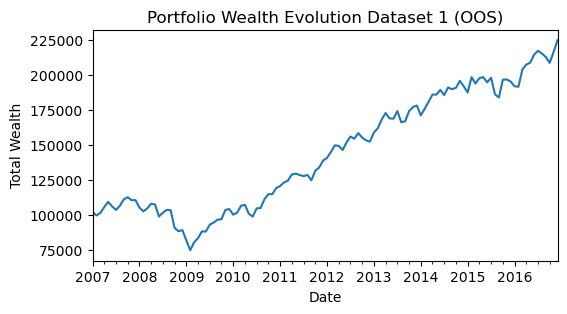

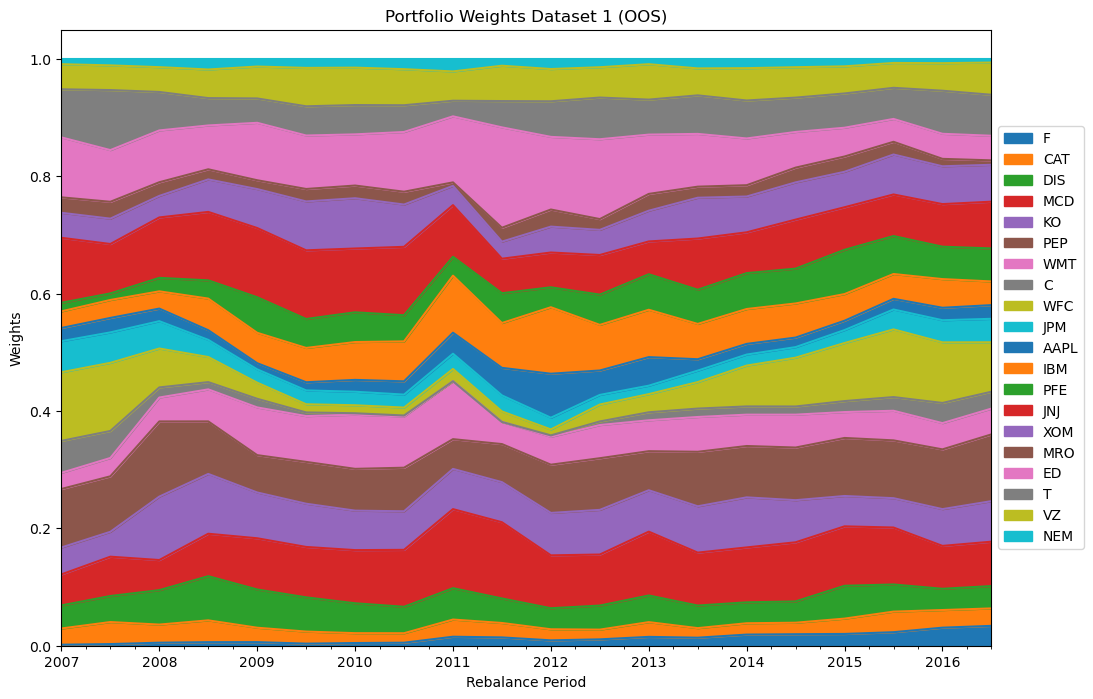

In [244]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = f'Portfolio Wealth Evolution Dataset {idx} (OOS)',
                ylabel = 'Total Wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig(f"images/wealth_ret_restrict_enet_data{idx}.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2)
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
# weights.columns = [col + 1 for col in weights.columns]
weights.columns = portfValue.resample('6ME').first().index[:x.shape[1]]
weights[(weights > 0).any(axis=1)].T.plot.area(title = f'Portfolio Weights Dataset {idx} (OOS)',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_size_inches(12, 8)
plt.savefig(f"images/weights_ret_restrict_enet_data{idx}.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

# Hyperparameter Tuning

In [85]:
# import tqdm
# # rewrite the loop to joblib
# def run_portfolio(hp_set,model_param):
#     # Start of out-of-sample test period
#     testStart = returns.index[0] + pd.offsets.DateOffset(years=5)
#     
#     #End of the first investment period
#     testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)
#     
#     # End of calibration period
#     calEnd = testStart -  pd.offsets.DateOffset(days = 1)
#     
#     # Total number of investment periods
#     NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)
#     
#     # Number of assets
#     n  = len(tickers)
#     if model_param >0:
#         objective_lambda_dict = {
#             'portfolio_variance': hp_set[0],
#             'turnover': hp_set[1],
#             'ellipsoidal_robustness':chi2.ppf(hp_set[2],n),
#             'cvar':hp_set[3],
#             'cvar_alpha':hp_set[4],
#             'enet_lambda': hp_set[5],
#             'enet_alpha': hp_set[6],
#             'prediction_model':model_param
#         }
#     else:
#         objective_lambda_dict = {
#             'portfolio_variance': hp_set[0],
#             'turnover': hp_set[1],
#             'ellipsoidal_robustness':chi2.ppf(hp_set[2],n),
#             'cvar':hp_set[3],
#             'cvar_alpha':hp_set[4],
#             'enet_lambda': 0,
#             'enet_alpha': 0,
#             'prediction_model':model_param
#         }
#     
#     # Preallocate space for the portfolio weights (x0 will be used to calculate
#     # the turnover rate)
#     x  = np.zeros([n, NoPeriods])
#     x0 = np.zeros([n, NoPeriods])
#     insample_r2 = np.zeros([n, NoPeriods])
#     
#     # Preallocate space for the portfolio per period value and turnover
#     currentVal = np.zeros([NoPeriods, 1])
#     turnover   = np.zeros([NoPeriods, 1])
#     
#     #Initiate counter for the number of observations per investment period
#     toDay = 0
#     
#     # Measure runtime: start the clock
#     # start_time = time.time()
#     
#     # Empty list to measure the value of the portfolio over the period
#     portfValue = []
#     
#     for t in range(NoPeriods):
#         # Subset the returns and factor returns corresponding to the current calibration period.
#         periodReturns = returns[returns.index <= calEnd]
#         periodFactRet = factorRet[factorRet.index <= calEnd]
#     
#         current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
#         currentPrices = adjClose[current_price_idx]
#     
#         # Subset the prices corresponding to the current out-of-sample test period.
#         periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
#         periodPrices = adjClose[periodPrices_idx]
#     
#         assert len(periodPrices) == investPeriod
#         assert len(currentPrices) == 1
#         # Set the initial value of the portfolio or update the portfolio value
#         if t == 0:
#             currentVal[0] = initialVal
#             #Initial portfolio weights
#             x0[:,0] = np.zeros(n)
#         else:
#             currentVal[t] = currentPrices @ NoShares.values.T
#             #Store the current asset weights (before optimization takes place)
#             x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
#     
#         #----------------------------------------------------------------------
#         # Portfolio optimization
#         # You must write code your own algorithmic trading function
#         # The project function is in the services folder
#         # Take in the period returns and period factor returns and produce
#         # an allocation
#         #----------------------------------------------------------------------
#         
#         x[:,t],insample_r2[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], objective_lambda_dict)
#         #Calculate the turnover rate
#         if t > 0:
#             turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )
#     
#         # Number of shares your portfolio holds per stock
#         NoShares = x[:,t]*currentVal[t]/currentPrices
#     
#         # Update counter for the number of observations per investment period
#         fromDay = toDay
#         toDay   = toDay + len(periodPrices)
#     
#         # Weekly portfolio value during the out-of-sample window
#         portfValue.append(periodPrices@ NoShares.values.T)
#     
#         # Update your calibration and out-of-sample test periods
#         testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
#         testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
#         calEnd    = testStart - pd.offsets.DateOffset(days=1)
#     
#     portfValue = pd.concat(portfValue, axis = 0)
#     # end_time = time.time()
#     # Calculate the observed portfolio returns
#     portfRets = portfValue.pct_change(1).iloc[1:,:]
#     
#     # Calculate the portfolio excess returns
#     portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)
#     
#     # Calculate the portfolio Sharpe ratio
#     portfolio_gmean = ((portfExRets + 1).apply(gmean, axis=0) - 1)
#     SR = portfolio_gmean/portfExRets.std()
#     
#     # Calculate the average turnover rate
#     avgTurnover = np.mean(turnover[1:])
#     portfolio_stats = {key:value for key,value in zip(['mvo_lambda', 'turnover_lambda', 'ellipsoidal_robustness', 'cvar_lambda', 'cvar_alpha', 'enet_lambda', 'enet_alpha', 'ENET_prediction_model'],hp_set)}
#     portfolio_stats['6 Month Excess Return'] = portfolio_gmean[0]
#     portfolio_stats['6 Month Sharpe_ratio'] = SR[0]
#     portfolio_stats['6 Month Avg_turnover'] = avgTurnover
#     portfolio_stats['6 Month Composite_Objective'] = 0.8*SR[0] - 0.2*(avgTurnover**2+avgTurnover)
#     portfolio_stats['Avg Insample_R2'] = np.mean(insample_r2)
#     portfolio_stats['Avg Deviation from 1/n'] = np.abs((x-1/n)).mean()
#     return portfolio_stats

In [86]:

# objective_lambda_dict = {
#         'portfolio_variance': 1,# this is fixed
#         'turnover': 0.01,
#         'ellipsoidal_robustness':chi2.ppf(0.95,n),
#         'cvar':0.1,
#         'cvar_alpha':0.95,
#         'enet_lambda':0.1,
#         'enet_alpha':0.95,
#         'prediction_model':1
#         # 'ellipsoidal_robustness':0,
#     }
# mvo_lambda = np.linspace(0,1,5)
# turnover_lambda = np.linspace(0,1,5)
# ellipsoidal_robustness = np.linspace(0.85,0.99,5)
# cvar_lambda = np.linspace(0,1,5)
# cvar_alpha = np.linspace(0.85,0.99,5)
# enet_lambda = np.linspace(-1,2,5)
# enet_alpha = np.linspace(0.0,1,5)
# search space 5**7+5**5=81250
# estimated time: 20 items per second, 156250/20 = 4062.5 seconds = 67.7 minutes = 1.128 hours

In [87]:
# ENET_portfolio_stats = Parallel(n_jobs=-1)(delayed(run_portfolio)(hp_set,1) for hp_set in tqdm.tqdm(itertools.product(mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,enet_lambda,enet_alpha)))



0it [00:00, ?it/s]

22it [00:00, 154.10it/s]

44it [00:04,  8.51it/s] 

66it [00:05, 11.52it/s]

88it [00:06, 13.56it/s]

110it [00:08, 14.38it/s]

132it [00:09, 15.03it/s]

154it [00:10, 16.23it/s]

176it [00:11, 16.87it/s]

198it [00:13, 15.28it/s]

220it [00:15, 13.60it/s]

242it [00:17, 12.83it/s]

264it [00:19, 12.46it/s]

286it [00:21, 12.10it/s]

308it [00:22, 12.34it/s]

330it [00:24, 12.56it/s]

352it [00:26, 12.82it/s]

374it [00:28, 12.77it/s]

396it [00:29, 12.68it/s]

418it [00:31, 12.01it/s]

440it [00:33, 11.55it/s]

462it [00:35, 11.45it/s]

484it [00:37, 11.60it/s]

506it [00:39, 11.63it/s]

528it [00:41, 12.45it/s]

550it [00:42, 12.81it/s]

572it [00:44, 12.28it/s]

594it [00:46, 12.10it/s]

616it [00:48, 11.82it/s]

638it [00:50, 12.24it/s]

660it [00:51, 12.11it/s]

682it [00:53, 12.81it/s]

704it [00:55, 13.04it/s]

726it [00:56, 13.55it/s]

748it [00:58, 13.24it/s]

770it [00:59, 13.30it/s]

792it [01:01, 12.62it/s]

814it [01:03, 12.69it/s]

836it [01:05, 12.1

In [88]:
# OLS_portfolio_stats = Parallel(n_jobs=-1)(delayed(run_portfolio)(hp_set,0) for hp_set in tqdm.tqdm(itertools.product(mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha)))



0it [00:00, ?it/s]

44it [00:00, 85.13it/s]

66it [00:01, 48.13it/s]

88it [00:02, 36.18it/s]

110it [00:03, 30.04it/s]

132it [00:04, 27.38it/s]

154it [00:04, 26.33it/s]

176it [00:06, 24.04it/s]

198it [00:06, 24.61it/s]

220it [00:07, 24.91it/s]

242it [00:08, 24.22it/s]

264it [00:09, 24.65it/s]

286it [00:10, 24.28it/s]

308it [00:11, 23.76it/s]

330it [00:12, 24.26it/s]

352it [00:13, 24.40it/s]

374it [00:14, 25.32it/s]

396it [00:14, 25.43it/s]

418it [00:15, 25.04it/s]

440it [00:16, 25.39it/s]

462it [00:17, 24.35it/s]

484it [00:18, 23.80it/s]

506it [00:19, 24.05it/s]

528it [00:20, 24.53it/s]

550it [00:21, 25.53it/s]

572it [00:21, 26.79it/s]

594it [00:22, 25.85it/s]

616it [00:23, 24.27it/s]

638it [00:24, 24.37it/s]

660it [00:25, 24.45it/s]

682it [00:26, 22.05it/s]

704it [00:27, 21.48it/s]

726it [00:29, 20.83it/s]

748it [00:29, 21.34it/s]

770it [00:31, 20.38it/s]

792it [00:32, 19.30it/s]

814it [00:33, 19.29it/s]

836it [00:34, 19.53it/s]

858it [00:35, 18.89

In [89]:
# pd.DataFrame(ENET_portfolio_stats).to_csv('ENET_portfolio_stats_ret_constraint.csv')
# pd.DataFrame(OLS_portfolio_stats).to_csv('OLS_portfolio_stats_ret_constraint.csv')

In [299]:
# ENET_portfolio_stats_df = pd.read_csv('ENET_portfolio_stats_ret_constraint.csv',index_col=0)

In [300]:
# OLS_portfolio_stats_df = pd.read_csv('OLS_portfolio_stats_ret_constraint.csv',index_col=0)

In [304]:
# ENET_portfolio_stats_df[ENET_portfolio_stats_df['enet_alpha']!=0].drop_duplicates(subset=['6 Month Composite_Objective']).sort_values('6 Month Composite_Objective',ascending=False).head(10)

,mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,enet_lambda,enet_alpha,6 Month Excess Return,6 Month Sharpe_ratio,6 Month Avg_turnover,6 Month Composite_Objective,Avg Insample_R2,Avg Deviation from 1/n
2501,0.00,0.0,0.990,0.0,0.85,-1.0,0.25,0.007211,0.197610,0.183919,0.114539,-0.090276,0.016671
1,0.00,0.0,0.850,0.0,0.85,-1.0,0.25,0.007211,0.197609,0.183918,0.114538,-0.090276,0.016671
1251,0.00,0.0,0.920,0.0,0.85,-1.0,0.25,0.007211,0.197608,0.183917,0.114538,-0.090276,0.016671
1876,0.00,0.0,0.955,0.0,0.85,-1.0,0.25,0.007211,0.197608,0.183916,0.114538,-0.090276,0.016671
626,0.00,0.0,0.885,0.0,0.85,-1.0,0.25,0.007211,0.197608,0.183917,0.114538,-0.090276,0.016671
18126,0.25,0.0,0.990,0.0,0.85,-1.0,0.25,0.007210,0.197625,0.184005,0.114527,-0.090276,0.016680
17501,0.25,0.0,0.955,0.0,0.85,-1.0,0.25,0.007210,0.197628,0.184017,0.114526,-0.090276,0.016682
16876,0.25,0.0,0.920,0.0,0.85,-1.0,0.25,0.007210,0.197628,0.184023,0.114525,-0.090276,0.016682
16251,0.25,0.0,0.885,0.0,0.85,-1.0,0.25,0.007210,0.197629,0.184028,0.114525,-0.090276,0.016683
15626,0.25,0.0,0.850,0.0,0.85,-1.0,0.25,0.007210,0.197630,0.184032,0.114524,-0.090276,0.016683


In [305]:
# OLS_portfolio_stats_df.drop_duplicates(subset=['6 Month Composite_Objective']).sort_values('6 Month Composite_Objective',ascending=False).head(10)

,mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,6 Month Excess Return,6 Month Sharpe_ratio,6 Month Avg_turnover,6 Month Composite_Objective,Avg Insample_R2,Avg Deviation from 1/n
100,0.00,0.0,0.990,0.0,0.85,0.007139,0.198398,0.188209,0.113992,0.362285,0.017560
0,0.00,0.0,0.850,0.0,0.85,0.007139,0.198397,0.188207,0.113992,0.362285,0.017560
25,0.00,0.0,0.885,0.0,0.85,0.007139,0.198397,0.188207,0.113992,0.362285,0.017560
75,0.00,0.0,0.955,0.0,0.85,0.007139,0.198397,0.188207,0.113991,0.362285,0.017560
50,0.00,0.0,0.920,0.0,0.85,0.007138,0.198395,0.188206,0.113991,0.362285,0.017560
725,0.25,0.0,0.990,0.0,0.85,0.007135,0.198417,0.188616,0.113895,0.362285,0.017606
700,0.25,0.0,0.955,0.0,0.85,0.007134,0.198420,0.188674,0.113882,0.362285,0.017613
675,0.25,0.0,0.920,0.0,0.85,0.007134,0.198422,0.188704,0.113875,0.362285,0.017616
650,0.25,0.0,0.885,0.0,0.85,0.007134,0.198423,0.188728,0.113870,0.362285,0.017619
625,0.25,0.0,0.850,0.0,0.85,0.007134,0.198424,0.188747,0.113865,0.362285,0.017621


# Return objective formulation:


In [152]:
# ENET_portfolio_stats_df_ret_tgt=pd.read_csv('ENET_portfolio_stats_ret_target.csv',index_col=0)
# OLS_portfolio_stats_df_ret_tgt=pd.read_csv('OLS_portfolio_stats_ret_target.csv',index_col=0)


In [153]:
# ENET_portfolio_stats_df_ret_tgt[ENET_portfolio_stats_df_ret_tgt['enet_alpha']!=0].drop_duplicates(subset=['6 Month Composite_Objective']).sort_values('6 Month Composite_Objective',ascending=False)

,mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,enet_lambda,enet_alpha,6 Month Excess Return,6 Month Sharpe_ratio,6 Month Avg_turnover,6 Month Composite_Objective,Avg Insample_R2,Avg Deviation from 1/n
15641,0.25,0.0,0.85,0.0,0.850,1.25,0.25,0.006243,0.173746,0.171025,0.098942,-0.054169,0.018357
16,0.00,0.0,0.85,0.0,0.850,1.25,0.25,0.006243,0.173746,0.171025,0.098942,-0.054169,0.018357
31266,0.50,0.0,0.85,0.0,0.850,1.25,0.25,0.006243,0.173746,0.171025,0.098942,-0.054169,0.018357
46891,0.75,0.0,0.85,0.0,0.850,1.25,0.25,0.006243,0.173745,0.171025,0.098942,-0.054169,0.018357
62516,1.00,0.0,0.85,0.0,0.850,1.25,0.25,0.006243,0.173745,0.171024,0.098942,-0.054169,0.018357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.00,0.0,0.85,1.0,0.885,-0.25,0.25,0.006196,0.178621,0.537030,-0.022190,0.091564,0.036551
506,0.00,0.0,0.85,1.0,0.850,-0.25,0.25,0.006196,0.178619,0.537029,-0.022190,0.091564,0.036551
556,0.00,0.0,0.85,1.0,0.920,-0.25,0.25,0.006196,0.178619,0.537029,-0.022190,0.091564,0.036551
581,0.00,0.0,0.85,1.0,0.955,-0.25,0.25,0.006196,0.178619,0.537031,-0.022191,0.091564,0.036551


In [154]:
# OLS_portfolio_stats_df_ret_tgt.drop_duplicates(subset=['6 Month Composite_Objective']).sort_values('6 Month Composite_Objective',ascending=False).head(10)

,mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,6 Month Excess Return,6 Month Sharpe_ratio,6 Month Avg_turnover,6 Month Composite_Objective,Avg Insample_R2,Avg Deviation from 1/n
100,0.00,0.0,0.990,0.0,0.85,0.006120,0.166410,0.181815,0.090154,0.362285,0.018578
725,0.25,0.0,0.990,0.0,0.85,0.006116,0.166405,0.182088,0.090075,0.362285,0.018623
1350,0.50,0.0,0.990,0.0,0.85,0.006112,0.166398,0.182360,0.089996,0.362285,0.018668
1975,0.75,0.0,0.990,0.0,0.85,0.006108,0.166392,0.182632,0.089916,0.362285,0.018713
2600,1.00,0.0,0.990,0.0,0.85,0.006104,0.166384,0.182902,0.089836,0.362285,0.018758
75,0.00,0.0,0.955,0.0,0.85,0.006087,0.165076,0.184273,0.088415,0.362285,0.018656
700,0.25,0.0,0.955,0.0,0.85,0.006082,0.165070,0.184572,0.088329,0.362285,0.018708
1325,0.50,0.0,0.955,0.0,0.85,0.006078,0.165064,0.184881,0.088239,0.362285,0.018759
1950,0.75,0.0,0.955,0.0,0.85,0.006073,0.165058,0.185188,0.088150,0.362285,0.018811
2575,1.00,0.0,0.955,0.0,0.85,0.006068,0.165051,0.185493,0.088061,0.362285,0.018862
